# Install requirements

In [66]:
# !pip install imbalanced-learn
# !pip install missingno
!pip install cuml

DEPRECATION: Loading egg at /home/mrwhite0racle/miniconda3/envs/flax/lib/python3.12/site-packages/flash_attn_jax-0.2.2-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached cuml-0.6.1.post1.tar.gz (1.1 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [47 lines of output]
      running bdist_wheel
      running build
      /home/mrwhite0racle/miniconda3/envs/flax/lib/python3.12/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
      !!
      
              ********************************************************************************
              Please avoid running ``setup.py`` directly.
              Instead, use pypa/build, pypa/ins

# Useful Imports

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

# Modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve

# Handling imbalanced data
from imblearn.over_sampling import SMOTE


# Data Loading

In [2]:
# Load data
data = pd.read_parquet('US_Accidents_2021to23.parquet')

# Convert 'Start_Time' to datetime and filter data from 2021 to 2023
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')
data = data[(data['Start_Time'] >= '2021-01-01') & (data['Start_Time'] <= '2023-12-31')]

print('Data shape:', data.shape)

# Display first few rows
data.head()


Data shape: (3572838, 46)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
512217,A-512230,Source2,1,2022-09-08 05:49:30,2022-09-08 06:34:53,41.946796,-88.208092,NaN,NaN,0.00,...,False,False,False,False,True,False,Night,Night,Day,Day
512218,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.00,...,False,False,False,False,False,False,Night,Night,Night,Night
512219,A-512232,Source2,1,2022-09-08 05:14:12,2022-09-08 07:38:17,37.542839,-77.441780,NaN,NaN,0.00,...,False,False,False,False,True,False,Night,Night,Night,Night
512220,A-512233,Source2,1,2022-09-08 06:22:57,2022-09-08 06:52:42,40.896629,-81.178452,NaN,NaN,0.00,...,False,False,False,False,False,False,Night,Night,Day,Day
512221,A-512234,Source2,2,2022-09-08 06:36:20,2022-09-08 07:05:58,41.409359,-81.644318,NaN,NaN,1.91,...,False,False,False,False,False,False,Night,Day,Day,Day


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3572838 entries, 512217 to 6928390
Data columns (total 46 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   Severity               int64         
 3   Start_Time             datetime64[ns]
 4   End_Time               object        
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   End_Lat                float64       
 8   End_Lng                float64       
 9   Distance(mi)           float64       
 10  Description            object        
 11  Street                 object        
 12  City                   object        
 13  County                 object        
 14  State                  object        
 15  Zipcode                object        
 16  Country                object        
 17  Timezone               object        
 18  Airport_Code          

In [4]:
data.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

# Data Preprocessing and Feature Engineering

**We have already done data exploration in the previous notebook. So we will directly start with feature engineering and modeling**

In [5]:
# Drop columns that are not useful for modeling
columns_to_drop = [
    'ID', 'End_Lat', 'End_Lng', 'Description', 'Street', 'End_Time', 
    'Source', 'Country', 'Zipcode', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
    'Turning_Loop' # Turning loops are all false
]

data.drop(columns=columns_to_drop, axis=1, inplace=True)

In [6]:
# Check missing values
print("Missing values before imputation:\n", data.isnull().sum())

Missing values before imputation:
 Severity                      0
Start_Time                    0
Start_Lat                     0
Start_Lng                     0
Distance(mi)                  0
City                        120
County                        0
State                         0
Temperature(F)            76914
Wind_Chill(F)            104953
Humidity(%)               81824
Pressure(in)              66711
Visibility(mi)            81131
Wind_Direction            94421
Wind_Speed(mph)           94405
Precipitation(in)        141287
Weather_Condition         77630
Amenity                       0
Bump                          0
Crossing                      0
Give_Way                      0
Junction                      0
No_Exit                       0
Railway                       0
Roundabout                    0
Station                       0
Stop                          0
Traffic_Calming               0
Traffic_Signal                0
Sunrise_Sunset            22762
Civil

In [7]:
df_imputed = data.copy()

# Numerical features to impute
numerical_features = ['Temperature(F)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Visibility(mi)']

# Impute numerical features with median
for col in numerical_features:
    median_value = df_imputed[col].median()
    df_imputed[col].fillna(median_value, inplace=True)

# Impute 'Weather_Condition' with mode
df_imputed['Weather_Condition'].fillna(df_imputed['Weather_Condition'].mode()[0], inplace=True)

# Check missing values after imputation
print("\nMissing values after imputation:\n", df_imputed.isnull().sum())

df = df_imputed.copy()

/tmp/ipykernel_6410/2089883727.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[col].fillna(median_value, inplace=True)
/tmp/ipykernel_6410/2089883727.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr


Missing values after imputation:
 Severity                      0
Start_Time                    0
Start_Lat                     0
Start_Lng                     0
Distance(mi)                  0
City                        120
County                        0
State                         0
Temperature(F)                0
Wind_Chill(F)            104953
Humidity(%)               81824
Pressure(in)              66711
Visibility(mi)                0
Wind_Direction            94421
Wind_Speed(mph)               0
Precipitation(in)             0
Weather_Condition             0
Amenity                       0
Bump                          0
Crossing                      0
Give_Way                      0
Junction                      0
No_Exit                       0
Railway                       0
Roundabout                    0
Station                       0
Stop                          0
Traffic_Calming               0
Traffic_Signal                0
Sunrise_Sunset            22762
Civil

### Temporal Features

In [8]:
# Extract temporal features from 'Start_Time'
df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year


In [9]:
# map hour to time of day
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df['TimeOfDay'] = df['Hour'].apply(get_time_of_day)
df['TimeOfDay'].value_counts()

TimeOfDay
Afternoon    1444201
Morning      1074694
Evening       676646
Night         377297
Name: count, dtype: int64

In [10]:
# map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)
df['Season'].value_counts()

Season
Winter    1193020
Spring     809848
Summer     787970
Fall       782000
Name: count, dtype: int64

In [11]:
# Simplify 'Weather_Condition'
def map_weather_condition(condition):
    if 'Rain' in condition or 'Drizzle' in condition or 'Showers' in condition:
        return 'Rain'
    elif 'Snow' in condition or 'Sleet' in condition or 'Hail' in condition:
        return 'Snow'
    elif 'Fog' in condition or 'Mist' in condition or 'Haze' in condition or 'Smoke' in condition:
        return 'Fog'
    elif 'Thunder' in condition or 'Storm' in condition:
        return 'Thunderstorm'
    elif 'Cloud' in condition or 'Overcast' in condition:
        return 'Cloudy'
    elif 'Clear' in condition or 'Fair' in condition:
        return 'Clear'
    elif 'Wind' in condition:
        return 'Windy'
    else:
        return 'Other'

df['Weather_Condition_Simple'] = df['Weather_Condition'].apply(map_weather_condition)
df['Weather_Condition_Simple'].value_counts()

Weather_Condition_Simple
Clear           1802192
Cloudy          1293483
Rain             230293
Fog               95454
Snow              94211
Thunderstorm      44659
Other             12106
Windy               440
Name: count, dtype: int64

In [12]:
# Convert boolean features to integers
bool_columns = ['Crossing', 'Junction', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Signal']
for col in bool_columns:
    df[col] = df[col].astype(int)

In [13]:
print("Data shape:", df.shape)
df.head()

Data shape: (3572838, 40)


,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),City,County,State,Temperature(F),Wind_Chill(F),...,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hour,DayOfWeek,Month,Year,TimeOfDay,Season,Weather_Condition_Simple
512217,1,2022-09-08 05:49:30,41.946796,-88.208092,0.00,Bartlett,DuPage,IL,58.0,58.0,...,Night,Day,Day,5,3,9,2022,Night,Fall,Clear
512218,1,2022-09-08 02:02:05,34.521172,-117.958076,0.00,Littlerock,Los Angeles,CA,86.0,86.0,...,Night,Night,Night,2,3,9,2022,Night,Fall,Clear
512219,1,2022-09-08 05:14:12,37.542839,-77.441780,0.00,Richmond,Richmond City,VA,68.0,68.0,...,Night,Night,Night,5,3,9,2022,Night,Fall,Cloudy
512220,1,2022-09-08 06:22:57,40.896629,-81.178452,0.00,Alliance,Stark,OH,62.0,62.0,...,Night,Day,Day,6,3,9,2022,Morning,Fall,Cloudy
512221,2,2022-09-08 06:36:20,41.409359,-81.644318,1.91,Independence,Cuyahoga,OH,63.0,63.0,...,Day,Day,Day,6,3,9,2022,Morning,Fall,Cloudy


### Cyclical Features

In [15]:
# We can try encode cyclical features using sin and cos functions, which 
# can also standardize the values and make it easier for the model to learn
# Cyclical encoding for 'Hour'
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for 'DayOfWeek'
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Cyclical encoding for 'Month'
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

In [16]:
# Drop columns that are no longer needed
df_processed = df
df_processed.drop(['Start_Time', 'Hour', 'DayOfWeek', 'Month', 'Year'], axis=1, inplace=True)

# # Categorical features to encode
# categorical_features = ['TimeOfDay', 'Season', 'Weather_Condition_Simple', 'State']

# # One-Hot Encoding
# df_processed = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

In [17]:
print("Data shape:", df_processed.shape)
df_processed.head()

Data shape: (3572838, 39)


,Severity,Start_Lat,Start_Lng,Distance(mi),City,County,State,Temperature(F),Wind_Chill(F),Humidity(%),...,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeOfDay,Season,Weather_Condition_Simple,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos
512217,1,41.946796,-88.208092,0.00,Bartlett,DuPage,IL,58.0,58.0,90.0,...,Night,Day,Day,Night,Fall,Clear,0.965926,2.588190e-01,0.433884,-0.900969
512218,1,34.521172,-117.958076,0.00,Littlerock,Los Angeles,CA,86.0,86.0,28.0,...,Night,Night,Night,Night,Fall,Clear,0.500000,8.660254e-01,0.433884,-0.900969
512219,1,37.542839,-77.441780,0.00,Richmond,Richmond City,VA,68.0,68.0,96.0,...,Night,Night,Night,Night,Fall,Cloudy,0.965926,2.588190e-01,0.433884,-0.900969
512220,1,40.896629,-81.178452,0.00,Alliance,Stark,OH,62.0,62.0,86.0,...,Night,Day,Day,Morning,Fall,Cloudy,1.000000,6.123234e-17,0.433884,-0.900969
512221,2,41.409359,-81.644318,1.91,Independence,Cuyahoga,OH,63.0,63.0,87.0,...,Day,Day,Day,Morning,Fall,Cloudy,1.000000,6.123234e-17,0.433884,-0.900969


In [18]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3572838 entries, 512217 to 6928390
Data columns (total 39 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Severity                  int64  
 1   Start_Lat                 float64
 2   Start_Lng                 float64
 3   Distance(mi)              float64
 4   City                      object 
 5   County                    object 
 6   State                     object 
 7   Temperature(F)            float64
 8   Wind_Chill(F)             float64
 9   Humidity(%)               float64
 10  Pressure(in)              float64
 11  Visibility(mi)            float64
 12  Wind_Direction            object 
 13  Wind_Speed(mph)           float64
 14  Precipitation(in)         float64
 15  Weather_Condition         object 
 16  Amenity                   bool   
 17  Bump                      bool   
 18  Crossing                  int64  
 19  Give_Way                  bool   
 20  Junction                

### Encoding non numerical features

In [46]:
# Identify columns with object or string data types
non_numeric_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

boolean_cols = df_processed.select_dtypes(include=['bool']).columns.tolist()
print("Boolean columns:", boolean_cols)

# Wind_Direction_Simple
wind_directions = df_processed['Wind_Direction'].unique()
wind_direction_mapping = {k: v for v, k in enumerate(wind_directions)}
df_processed['Wind_Direction_Encoded'] = df_processed['Wind_Direction'].map(wind_direction_mapping)

# Weather_Condition
weather_conditions = df_processed['Weather_Condition'].unique()
weather_condition_mapping = {k: v for v, k in enumerate(weather_conditions)}
df_processed['Weather_Condition_Encoded'] = df_processed['Weather_Condition'].map(weather_condition_mapping)

# TimeOfDay
time_of_day_order = {'Night': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3}
df_processed['TimeOfDay_Encoded'] = df_processed['TimeOfDay'].map(time_of_day_order)

# Season
season_order = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
df_processed['Season_Encoded'] = df_processed['Season'].map(season_order)

# Twilight Columns
twilight_mapping = {'Day': 0, 'Night': 1}
df_processed['Sunrise_Sunset_Encoded'] = df_processed['Sunrise_Sunset'].map(twilight_mapping)
df_processed['Civil_Twilight_Encoded'] = df_processed['Civil_Twilight'].map(twilight_mapping)
df_processed['Nautical_Twilight_Encoded'] = df_processed['Nautical_Twilight'].map(twilight_mapping)
df_processed['Astronomical_Twilight_Encoded'] = df_processed['Astronomical_Twilight'].map(twilight_mapping)


# State
state_mapping = {state: i for i, state in enumerate(df_processed['State'].unique())}
df_processed['State_Encoded'] = df_processed['State'].map(state_mapping)

# County
county_mapping = {county: i for i, county in enumerate(df_processed['County'].unique())}
df_processed['County_Encoded'] = df_processed['County'].map(county_mapping)

# City
city_mapping = {city: i for i, city in enumerate(df_processed['City'].unique())}
df_processed['City_Encoded'] = df_processed['City'].map(city_mapping)

df_processed.info()

Non-numeric columns: ['City', 'County', 'State', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'TimeOfDay', 'Season', 'Weather_Condition_Simple']
Boolean columns: ['Amenity', 'Bump', 'Give_Way', 'No_Exit', 'Traffic_Calming']
<class 'pandas.core.frame.DataFrame'>
Index: 3572838 entries, 512217 to 6928390
Data columns (total 50 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Severity                       int64  
 1   Start_Lat                      float64
 2   Start_Lng                      float64
 3   Distance(mi)                   float64
 4   City                           object 
 5   County                         object 
 6   State                          object 
 7   Temperature(F)                 float64
 8   Wind_Chill(F)                  float64
 9   Humidity(%)                    float64
 10  Pressure(in)                   float64
 11  Visibility

In [47]:
non_numeric_cols

['City',
 'County',
 'State',
 'Wind_Direction',
 'Weather_Condition',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight',
 'TimeOfDay',
 'Season',
 'Weather_Condition_Simple']

In [48]:
# Identify numerical features
numerical_features = df_processed.select_dtypes(include=[np.number, np.float64, bool]).columns.tolist()


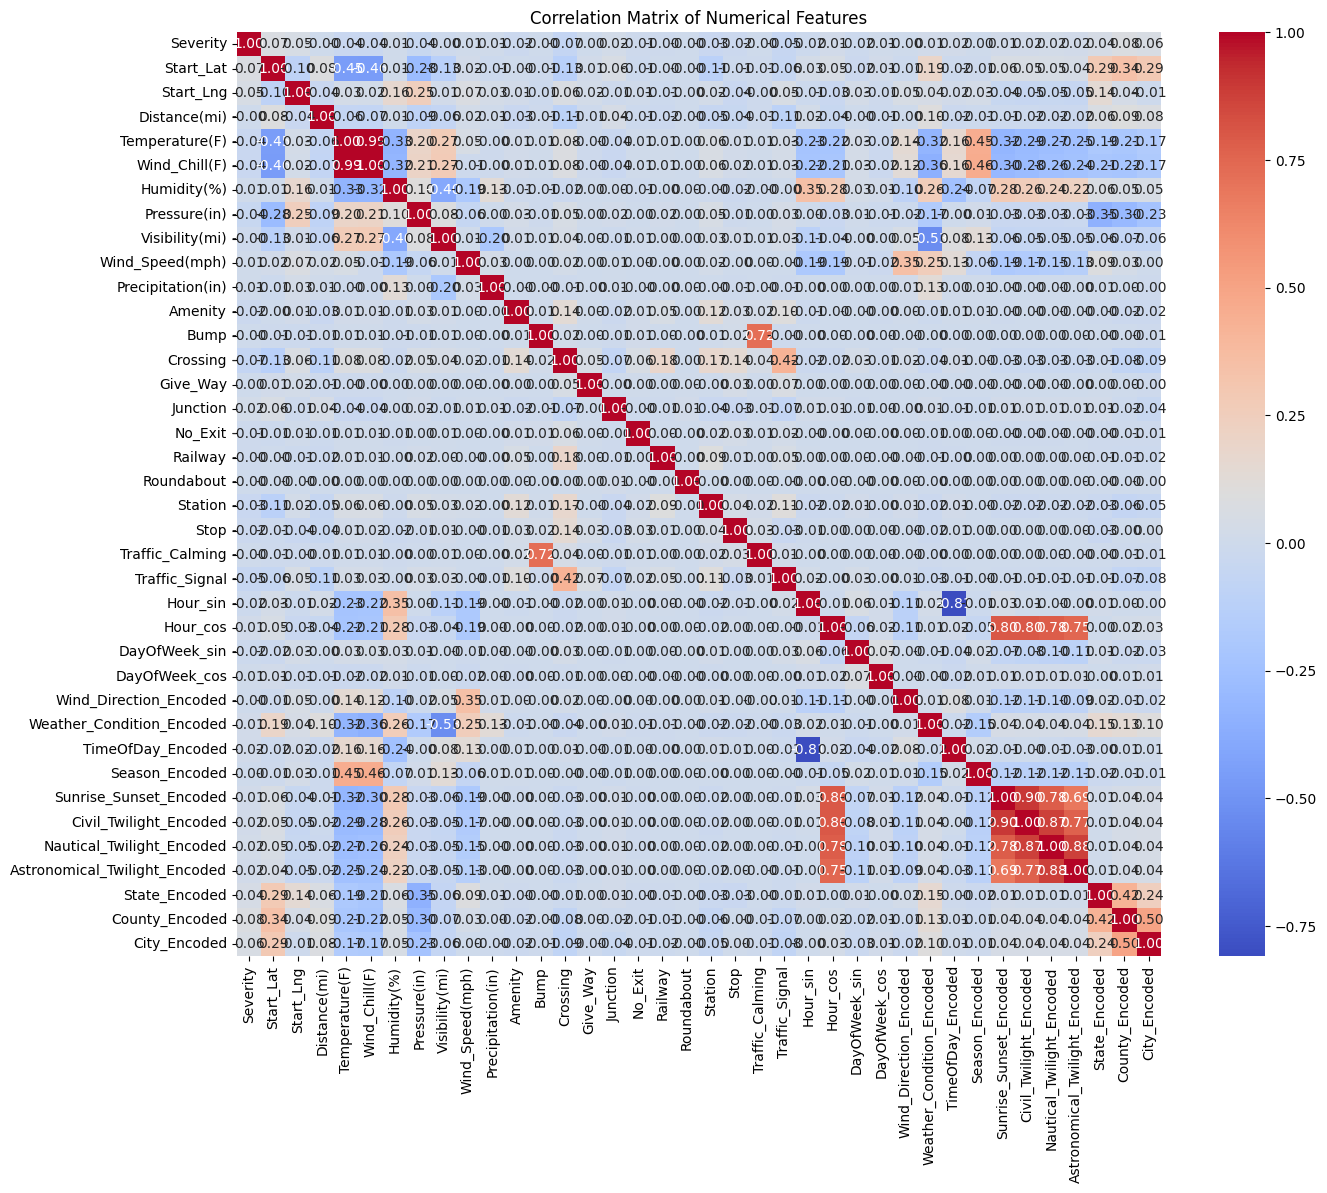

Correlation of features with 'Severity':
 Severity                         1.000000
County_Encoded                   0.075649
Start_Lat                        0.067361
City_Encoded                     0.059765
Start_Lng                        0.052944
State_Encoded                    0.041550
Nautical_Twilight_Encoded        0.018499
Junction                         0.017768
Astronomical_Twilight_Encoded    0.017343
TimeOfDay_Encoded                0.017029
Civil_Twilight_Encoded           0.016418
Weather_Condition_Encoded        0.014275
Sunrise_Sunset_Encoded           0.014061
Hour_cos                         0.012290
DayOfWeek_cos                    0.008809
Precipitation(in)                0.006099
Humidity(%)                      0.005795
Wind_Speed(mph)                  0.005682
Season_Encoded                   0.000667
Give_Way                         0.000194
Wind_Direction_Encoded          -0.000079
Roundabout                      -0.001140
Traffic_Calming                 -0

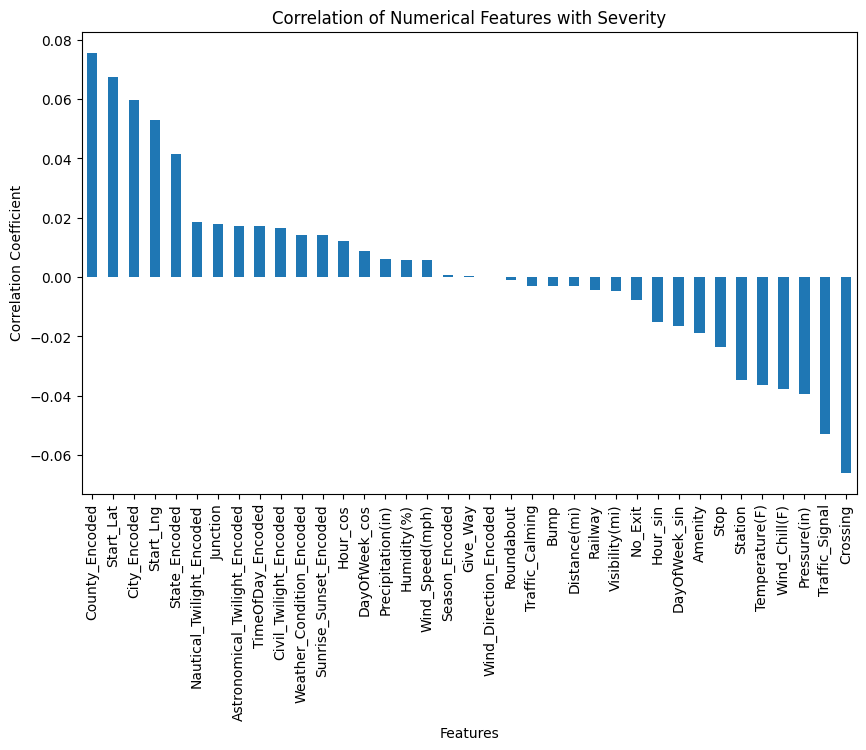

In [49]:
# Identify numerical features
numerical_features = df_processed.select_dtypes(include=[np.number, np.float64, bool]).columns.tolist()

if 'Severity' not in numerical_features:
    numerical_features.append('Severity')

# Create a DataFrame with only numerical features
df_numeric = df_processed[numerical_features]

# Compute the correlation matrix
corr_matrix = df_numeric.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Get the correlation of all features with 'Severity'
severity_corr = corr_matrix['Severity'].sort_values(ascending=False)

print("Correlation of features with 'Severity':\n", severity_corr)

severity_corr = severity_corr.drop('Severity')

# Plot the correlations
plt.figure(figsize=(10, 6))
severity_corr.plot(kind='bar')
plt.title('Correlation of Numerical Features with Severity')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()


In [50]:
# Select all the numerical features
df_final = df_processed.select_dtypes(include=[np.number, np.float64, bool])
df_final.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3572838 entries, 512217 to 6928390
Data columns (total 38 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Severity                       int64  
 1   Start_Lat                      float64
 2   Start_Lng                      float64
 3   Distance(mi)                   float64
 4   Temperature(F)                 float64
 5   Wind_Chill(F)                  float64
 6   Humidity(%)                    float64
 7   Pressure(in)                   float64
 8   Visibility(mi)                 float64
 9   Wind_Speed(mph)                float64
 10  Precipitation(in)              float64
 11  Amenity                        bool   
 12  Bump                           bool   
 13  Crossing                       int64  
 14  Give_Way                       bool   
 15  Junction                       int64  
 16  No_Exit                        bool   
 17  Railway                        int64  
 18  Ro

## Investigating missing values

In [51]:
# Find columns with nan values
nan_cols = df_final.columns[df_final.isnull().any()].tolist()

print("Columns with missing values:", nan_cols)

df_final.isnull().sum().sort_values(ascending=False)
# see are the missing value by Percentage
missing_percentage = df_final.isnull().sum().sort_values(ascending=False)/len(data)*100
missing_percentage

Columns with missing values: ['Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Sunrise_Sunset_Encoded', 'Civil_Twilight_Encoded', 'Nautical_Twilight_Encoded', 'Astronomical_Twilight_Encoded']


Wind_Chill(F)                    2.937525
Humidity(%)                      2.290168
Pressure(in)                     1.867171
Sunrise_Sunset_Encoded           0.637085
Astronomical_Twilight_Encoded    0.637085
Nautical_Twilight_Encoded        0.637085
Civil_Twilight_Encoded           0.637085
Weather_Condition_Encoded        0.000000
Hour_sin                         0.000000
Hour_cos                         0.000000
DayOfWeek_sin                    0.000000
DayOfWeek_cos                    0.000000
Wind_Direction_Encoded           0.000000
Severity                         0.000000
TimeOfDay_Encoded                0.000000
Season_Encoded                   0.000000
Traffic_Calming                  0.000000
State_Encoded                    0.000000
County_Encoded                   0.000000
Traffic_Signal                   0.000000
Station                          0.000000
Stop                             0.000000
Amenity                          0.000000
Start_Lng                        0

- 'Wind_Chill(F)': Wind chill is typically calculated when the temperature is below a certain threshold and wind speed is significant. Missing values might occur when it's warm, and wind chill is not relevant.
- 'Humidity(%)' and 'Pressure(in)': Missingness might be related to weather conditions or measurement errors.
- Twilight Columns: These are derived from the time of day and geographical location. Missing values might be due to missing timestamps or locations.

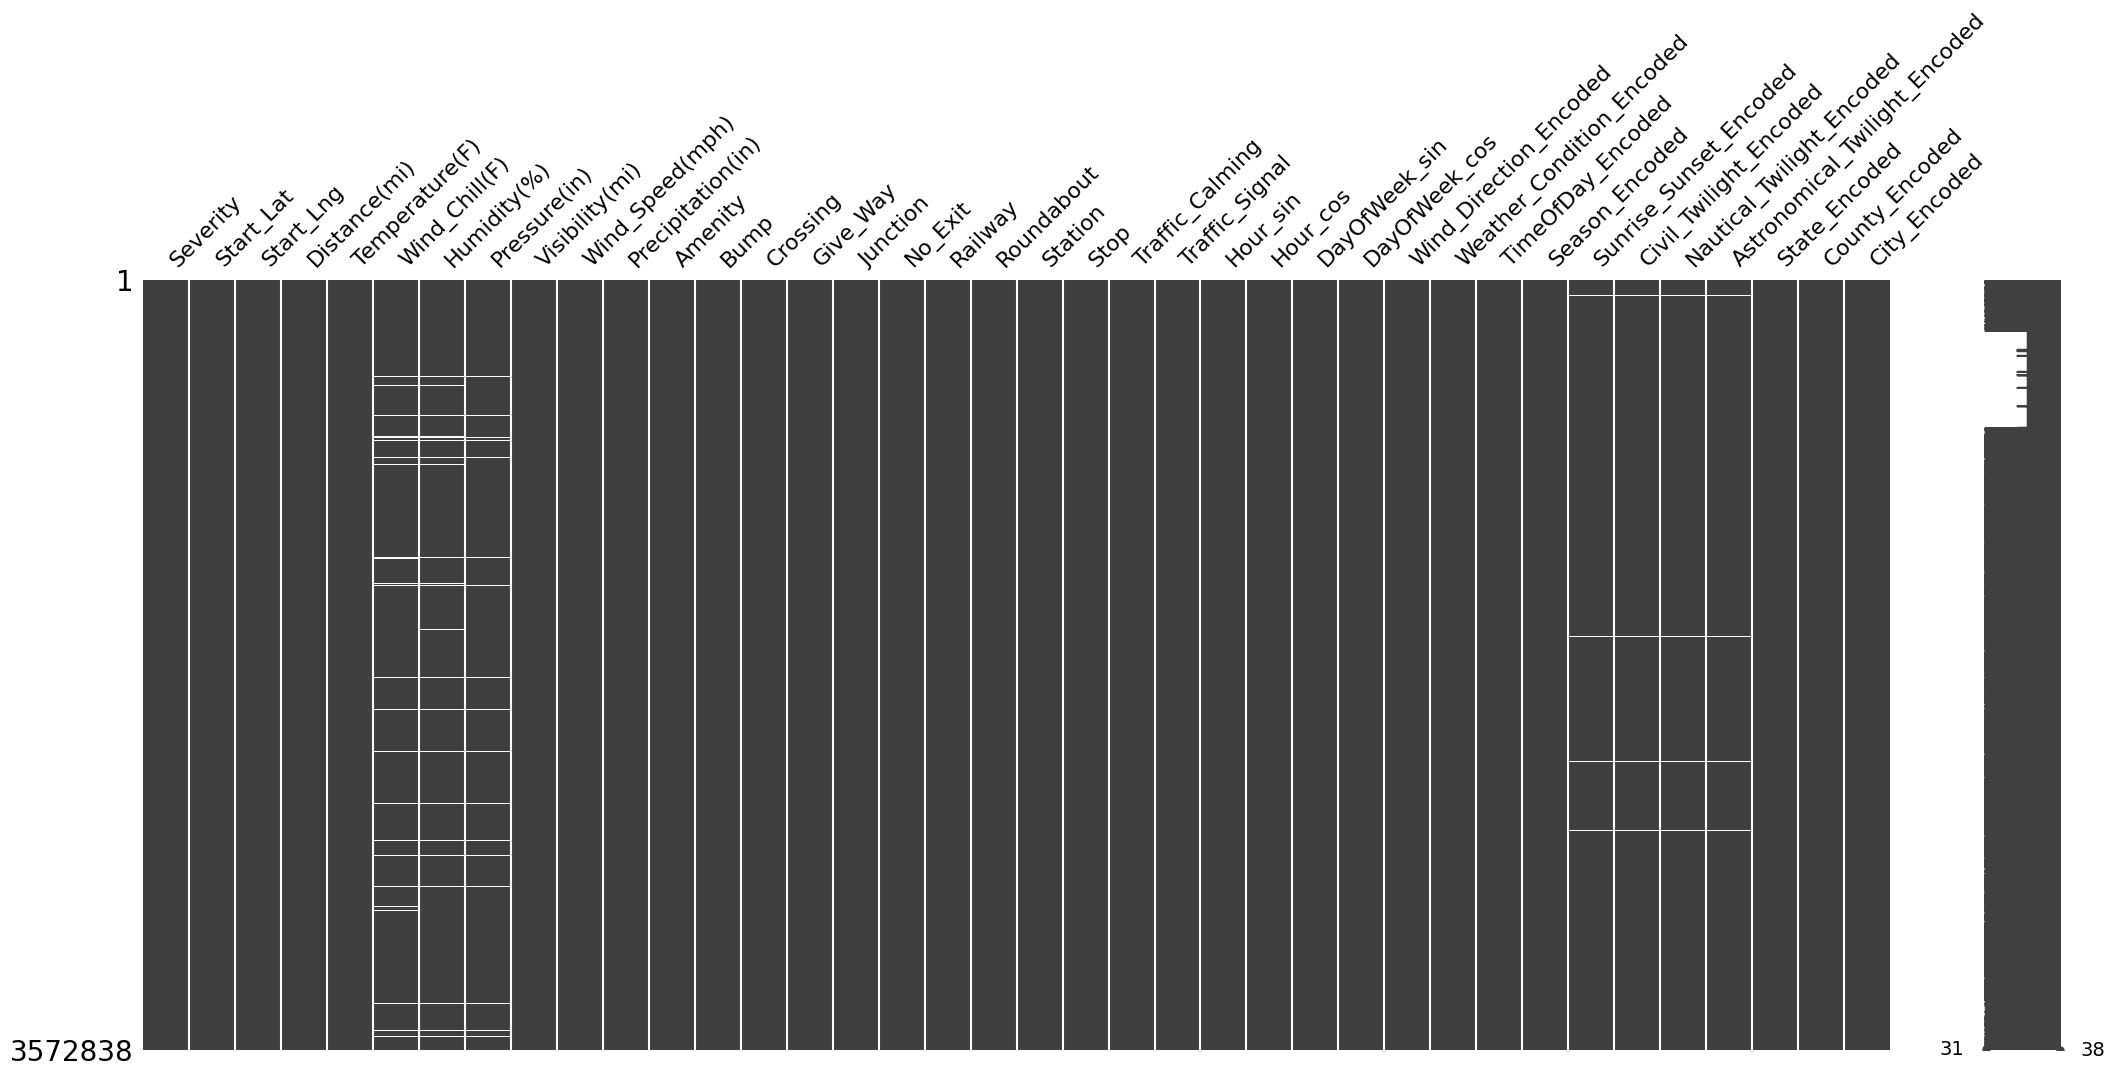

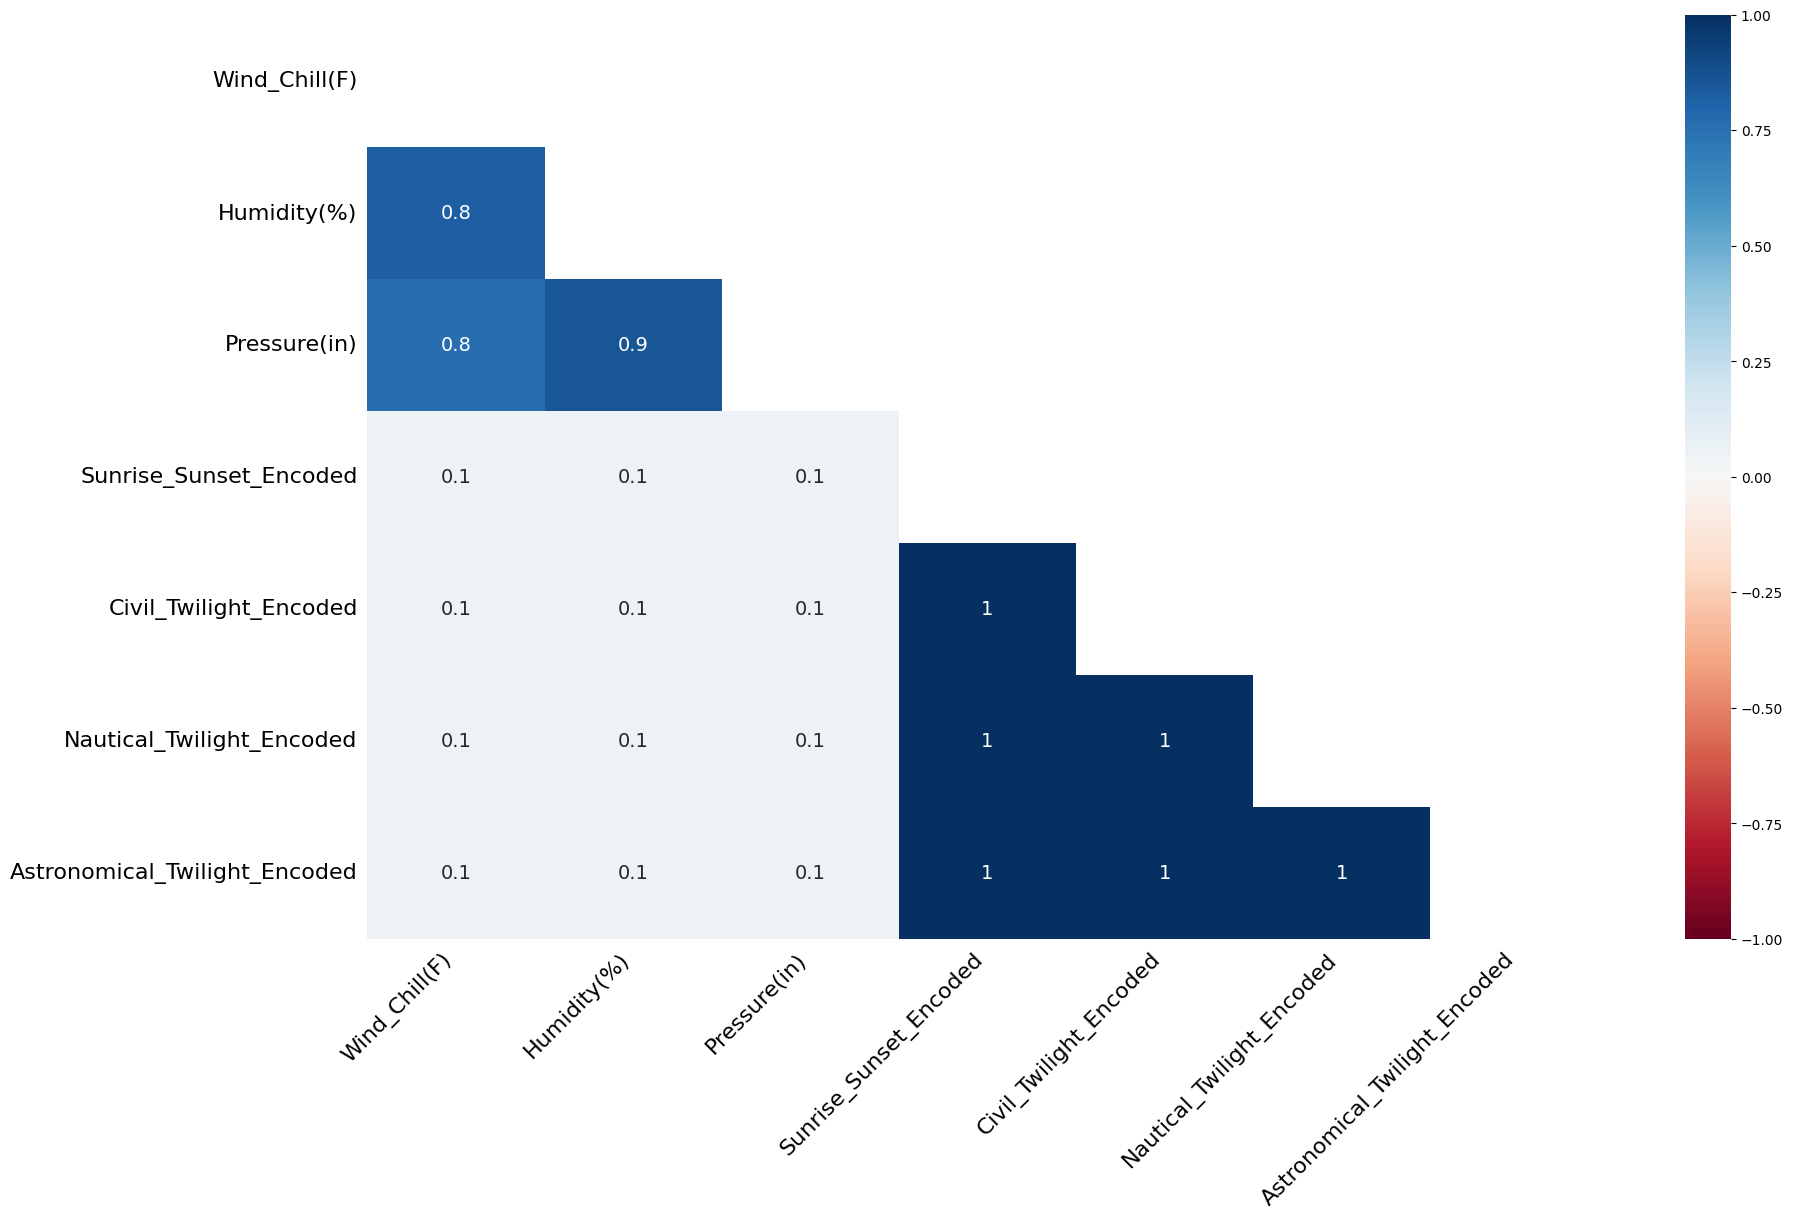

In [52]:
import missingno as msno

# Visualize missing data matrix
msno.matrix(df_final)
plt.show()

# Visualize missing data heatmap
msno.heatmap(df_final)
plt.show()

In [53]:
# We can just take the Nautilus_Twilight_Encoded and drop the rest
df_final.drop(columns=['Sunrise_Sunset_Encoded', 'Civil_Twilight_Encoded', 'Astronomical_Twilight_Encoded'], inplace=True)

### IterativeImputer and Mode imputers from SKLearn to the rescue!
Because KNNImputer is too slow

In [54]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # To use IterativeImputer
from sklearn.impute import IterativeImputer

features_for_imputation = df_final.drop(columns=['Severity'])

# Identify columns to impute
columns_to_impute = ['Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)']

# Initialize IterativeImputer
iter_imputer = IterativeImputer(max_iter=10, random_state=42)

# Fit and transform the data
df_imputed = df_final.copy()
df_imputed[columns_to_impute] = iter_imputer.fit_transform(df_imputed[columns_to_impute])

In [55]:
mode_imputer = SimpleImputer(strategy='most_frequent')
df_imputed[['Nautical_Twilight_Encoded']] = mode_imputer.fit_transform(df_imputed[['Nautical_Twilight_Encoded']])

In [56]:
# Check for remaining missing values
remaining_missing = df_imputed.isnull().mean() * 100
remaining_missing = remaining_missing[remaining_missing > 0]
print("Remaining missing values after imputation:\n", remaining_missing)

Remaining missing values after imputation:
 Series([], dtype: float64)


In [57]:
# Check class distribution
print("Class distribution before resampling:\n", df_imputed['Severity'].value_counts())

Class distribution before resampling:
 Severity
2    3227546
3     226042
4      81224
1      38026
Name: count, dtype: int64


In [88]:
# We can club the severity 1 and 2 as they are less severe, and 3 and 4 as they are more severe
df_imputed['Severity_clubbed'] = df_imputed['Severity'].copy().replace({1: 0, 2: 0, 3: 1, 4: 1})
# Check class distribution
print("Class distribution:\n", df_imputed['Severity_clubbed'].value_counts())

Class distribution:
 Severity_clubbed
0    3265572
1     307266
Name: count, dtype: int64


## Standardize the data

In [89]:
# Identify numerical features (excluding the target variable and the clubbed severity)
numerical_features = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('Severity')
numerical_features.remove('Severity_clubbed')

# Exclude binary variables (encoded booleans), as scaling 0 and 1 isn't necessary
binary_columns = [col for col in numerical_features if df_imputed[col].nunique() == 2]
numerical_features = [col for col in numerical_features if col not in binary_columns]

print("Numerical features to be standardized:\n", numerical_features)

Numerical features to be standardized:
 ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Wind_Direction_Encoded', 'Weather_Condition_Encoded', 'TimeOfDay_Encoded', 'Season_Encoded', 'State_Encoded', 'County_Encoded', 'City_Encoded']


In [90]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Standardize the numerical features
df_scaled = df_imputed.copy()
df_scaled = scaler.fit_transform(df_scaled)

In [91]:
df_imputed.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Hour_sin', 'Hour_cos',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'Wind_Direction_Encoded',
       'Weather_Condition_Encoded', 'TimeOfDay_Encoded', 'Season_Encoded',
       'Nautical_Twilight_Encoded', 'State_Encoded', 'County_Encoded',
       'City_Encoded', 'Severity_clubbed'],
      dtype='object')

### Handle Class Imbalance

In [92]:
# Separate features and target variable
X = df_imputed.drop(['Severity_clubbed', 'Severity'], axis=1)
y = df_imputed['Severity_clubbed']

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=4
)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("\nClass distribution after resampling:\n", y_train_resampled.value_counts())


Class distribution after resampling:
 Severity_clubbed
0    2612457
1    2612457
Name: count, dtype: int64


In [93]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2858270 entries, 3704452 to 6086755
Data columns (total 34 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Start_Lat                  float64
 1   Start_Lng                  float64
 2   Distance(mi)               float64
 3   Temperature(F)             float64
 4   Wind_Chill(F)              float64
 5   Humidity(%)                float64
 6   Pressure(in)               float64
 7   Visibility(mi)             float64
 8   Wind_Speed(mph)            float64
 9   Precipitation(in)          float64
 10  Amenity                    bool   
 11  Bump                       bool   
 12  Crossing                   int64  
 13  Give_Way                   bool   
 14  Junction                   int64  
 15  No_Exit                    bool   
 16  Railway                    int64  
 17  Roundabout                 int64  
 18  Station                    int64  
 19  Stop                       int64  
 20  T

# Modeling

In [99]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    solver='newton-cholesky',
    random_state=42,
    n_jobs=-1
)
lr.fit(X_train_resampled[:100000], y_train_resampled[:100000])
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Performance:")
print("Test Accuracy: ", accuracy_score(y_test, y_pred_lr), "Train Accuracy: ", accuracy_score(y_train_resampled[:100000], lr.predict(X_train_resampled[:100000])))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Performance:
Test Accuracy:  0.9139997872840654 Train Accuracy:  0.9137


/home/mrwhite0racle/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mrwhite0racle/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96    653115
           1       0.00      0.00      0.00     61453

    accuracy                           0.91    714568
   macro avg       0.46      0.50      0.48    714568
weighted avg       0.84      0.91      0.87    714568

Confusion Matrix:
 [[653115      0]
 [ 61453      0]]


/home/mrwhite0racle/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [100]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_resampled[:1000000], y_train_resampled[:1000000])
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf), "Train Accuracy:", accuracy_score(y_train_resampled[:1000000], rf.predict(X_train_resampled[:1000000])))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Performance:
Test Accuracy: 0.9369325242664099 Train Accuracy: 0.995329
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97    653115
           1       0.71      0.45      0.55     61453

    accuracy                           0.94    714568
   macro avg       0.83      0.72      0.76    714568
weighted avg       0.93      0.94      0.93    714568

Confusion Matrix:
 [[641706  11409]
 [ 33657  27796]]


In [101]:
# Random Forest Classifier
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_resampled[:1000000], y_train_resampled[:1000000])
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Performance:")
print("Test, Accuracy:", accuracy_score(y_test, y_pred_xgb), "Train Accuracy:", accuracy_score(y_train_resampled[:1000000], xgb.predict(X_train_resampled[:1000000])))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Performance:
Test, Accuracy: 0.9392570056313745 Train Accuracy: 0.940838
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97    653115
           1       0.76      0.43      0.55     61453

    accuracy                           0.94    714568
   macro avg       0.86      0.71      0.76    714568
weighted avg       0.93      0.94      0.93    714568

Confusion Matrix:
 [[644974   8141]
 [ 35264  26189]]


# Preliminary Model Evaluation Results

The poor performance of the Logistic Regression model suggests that the relationship between the variables and accident severity is non-linear. Since Logistic Regression relies on a linear decision boundary, it fails to capture the complex interactions within the data. In contrast, tree-based models like Random Forest and XGBoost demonstrated significantly better performance by effectively modeling these non-linear relationships and interactions among variables.

These tree-based models also provide valuable insights into feature importance, helping to identify key factors that influence accident severity, such as weather conditions, time of day, and road characteristics. While high training accuracy in these models indicates potential overfitting, the relatively high test accuracy suggests they generalize well to unseen data. Employing techniques like cross-validation and hyperparameter tuning can further reduce the risk of overfitting.

Addressing class imbalance using SMOTE was crucial in enhancing model performance, ensuring that all classes were adequately represented during training. This approach prevents bias toward the majority class and improves the model's ability to predict minority class instances accurately. Given its superior performance, robustness, and efficiency, XGBoost emerges as the preferred model for predicting accident severity in this context.